In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
sig = torch.nn.Sigmoid()
soft = torch.nn.Softmax(dim=1)
tanh = torch.nn.Tanh()

def f(txt,mapping):
    return [mapping[key] for key in txt] 

In [5]:
# (사용 예시) - 원핫인코딩 version
txt = ['a','b','a']
mapping = {'a':[1,0],'b':[0,1]}

## Exam1: ab

In [6]:
txt = list('ab')*100

In [7]:
txt_x = txt[:-1] # 처음부터 마지막 하나 빼고
txt_y = txt[1:] # 처음빼고 마지막까지

### 선형모형을 이용한 풀이

#### ***(풀이1) 1개의 파라메터 - 실패***

`-` 데이터정리 

In [8]:
x = torch.tensor(f(txt_x,{'a':0,'b':1})).float().reshape(-1,1)
y = torch.tensor(f(txt_y,{'a':0,'b':1})).float().reshape(-1,1)

`-` 학습 및 결과 시각화

In [9]:
net = torch.nn.Linear(1,1,bias=False) # one parameter
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

In [10]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

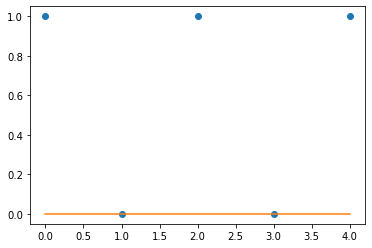

In [11]:
plt.plot(y[:5],'o')
plt.plot(net(x).data[:5])

`-` 학습이 잘 안된 이유?

현재 $y_i \approx \hat{w}x_i$ (parameter개수 = 1)가 되는 적당한 $\hat{w}$를 찾아야 하는 상황 
- $(x_i,y_i)=(0,1)$ 이면 어떠한 $\hat{w}$를 선택해도 $y_i \approx \hat{w}x_i$를 만드는 것이 불가능  
- $(x_i,y_i)=(1,0)$ 이면 $\hat{w}=0$일 경우 $y_i \approx \hat{w}x_i$로 만드는 것이 가능 

상황을 종합해보니 $\hat{w}=0$으로 학습되는 것이 그나마 최선

#### ***(풀이2) 1개의 파라메터 - 성공, but 확장성 없는 풀이***

`-` 0이라는 값이 문제가 되므로 인코딩방식의 변경

In [12]:
x = torch.tensor(f(txt_x,{'a':-1,'b':1})).float().reshape(-1,1) 
y = torch.tensor(f(txt_y,{'a':-1,'b':1})).float().reshape(-1,1)

In [13]:
net = torch.nn.Linear(1,1,bias=False)
loss_fn = torch.nn.MSELoss()
optimizr = torch.optim.Adam(net.parameters())

In [14]:
for epoc in range(20000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

`-` 결과는 성공

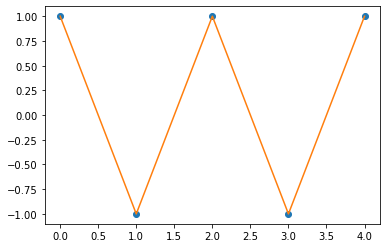

In [15]:
plt.plot(y[:5],'o')
plt.plot(net(x).data[:5])

In [16]:
list(net.parameters())

[Parameter containing:
 tensor([[-1.]], requires_grad=True)]

> 딱봐도 클래스가 3개일 경우 확장이 어려워 보인다. 

### 로지스틱 모형을 이용한 풀이

#### ***(풀이1) 1개의 파라메터 -- 실패***

`-` 데이터를 다시 a=0, b=1로 정리

In [35]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

In [36]:
net = torch.nn.Linear(1,1,bias=False)
loss_fn = torch.nn.BCEWithLogitsLoss() # 로지스틱 모형을 이용한 풀이
optimizr = torch.optim.Adam(net.parameters())

In [37]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

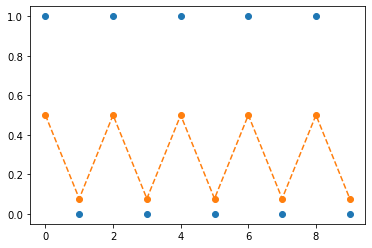

In [38]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 결과해석: 예상되었던 실패임 
- 아키텍처는 $\hat{y}_i = \text{sig}(\hat{w}x_i)$ 꼴이다. 
- $(x_i,y_i)=(0,1)$ 이라면 어떠한 $\hat{w}$을 선택해도 $\hat{w}x_i=0$ 이다. 이경우 $\hat{y}_i = \text{sig}(0) = 0.5$ 가 된다. 
  - bias를 할당해줌으로써 해결이 가능해보인다
- $(x_i,y_i)=(1,0)$ 이라면 $\hat{w}=-5$와 같은 값으로 선택하면 $\text{sig}(-5) \approx 0 = y_i$ 와 같이 만들 수 있다. 
- $sigmoid = \frac{e^x}{1+e^x}$
- 상황을 종합하면 net의 weight는 $\text{sig}(\hat{w}x_i) \approx 0$ 이 되도록 적당한 음수로 학습되는 것이 최선임을 알 수 있다. 

In [39]:
net.weight # 적당한 음수값으로 학습되어있음을 확인

Parameter containing:
tensor([[-2.4808]], requires_grad=True)

#### ***(풀이2) 2개의 파라메터 + 좋은 초기값 -- 성공***

In [40]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

`-` 네트워크에서 bias를 넣기로 결정함 

In [41]:
net = torch.nn.Linear(1,1,bias=True)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())

`-` net의 초기값을 설정 (좋은 초기값)

In [42]:
net.weight.data = torch.tensor([[-5.00]])
net.bias.data = torch.tensor([+2.500])

`-` 학습전 결과

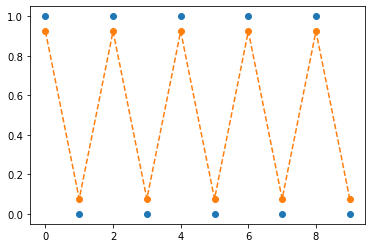

In [43]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 학습후결과

In [44]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

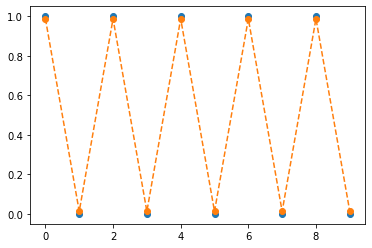

In [45]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

#### ***(풀이3) 2개의 파라메터 + 나쁜초기값 -- 성공***

`-` a=0, b=1 

In [46]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

`-` 이전과 동일하게 바이어스가 포함된 네트워크 설정 

In [47]:
net = torch.nn.Linear(1,1,bias=True)
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizr = torch.optim.Adam(net.parameters())

`-` 초기값설정 (이 초기값은 나쁜 초기값임)

In [48]:
net.weight.data = torch.tensor([[+5.00]])
net.bias.data = torch.tensor([-2.500])

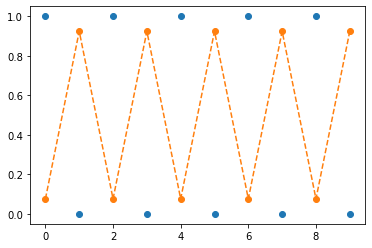

In [49]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

`-` 학습

In [50]:
for epoc in range(50000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

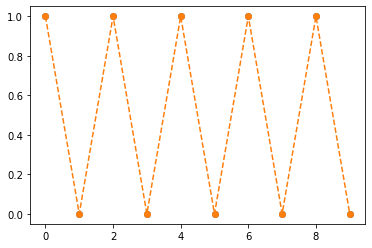

In [51]:
plt.plot(y[:10],'o')
plt.plot(sig(net(x)).data[:10],'--o')

- loop을 상당히 돌리긴 했지만 수렴하긴 함

#### ***(풀이4) 3개의 파라메터를 쓴다면?***

`-` a=0, b=1로 코딩 

In [52]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,1)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,1)

`-` 3개의 파라메터를 사용하기 위해서 아래와 같은 구조를 생각하자. 

```Python
torch.nn.Sequential(
    torch.nn.Linear(1,1,bias=True), # 2개의 파라미터
    torch.nn.ACTIVATION_FUNCTION(), # 활성화 함수
    torch.nn.Linear(1,1,bias=False) # 1개의 파라미터
)
````

- 위와 같은 네트워크를 설정하면 3개의 파라메터를 사용할 수 있다.
- 적절한 ACTIVATION_FUNCTION을 골라야 하는데 실험적으로 tanh가 적절하다고 알려져있다 $\to$ 그래서 우리도 실험적으로 이해해보자

--- 

(예비학습1) 

In [19]:
net.forward = lambda x: 1 

In [21]:
net(x) == net.forward(x)

True

(예비학습2) 

In [41]:
# sigmoid
class Mynet1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1,1,bias=True)
        ########################################
        self.a1 = torch.nn.Sigmoid()
        ########################################
        self.l2 = torch.nn.Linear(1,1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

In [42]:
# ReLU
class Mynet2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1,1,bias=True)
        ########################################
        self.a1 = torch.nn.ReLU()
        ########################################
        self.l2 = torch.nn.Linear(1,1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

In [43]:
# Tanh
class Mynet3(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = torch.nn.Linear(1,1,bias=True)
        ########################################
        self.a1 = torch.nn.Tanh()
        ########################################
        self.l2 = torch.nn.Linear(1,1,bias=False)
    def forward(self,x):
        yhat = self.l2(self.a1(self.l1(x)))
        return yhat

--- 

> ### 활성화함수로서 tanh가 왜 적절한지 직관을 얻어보자. 

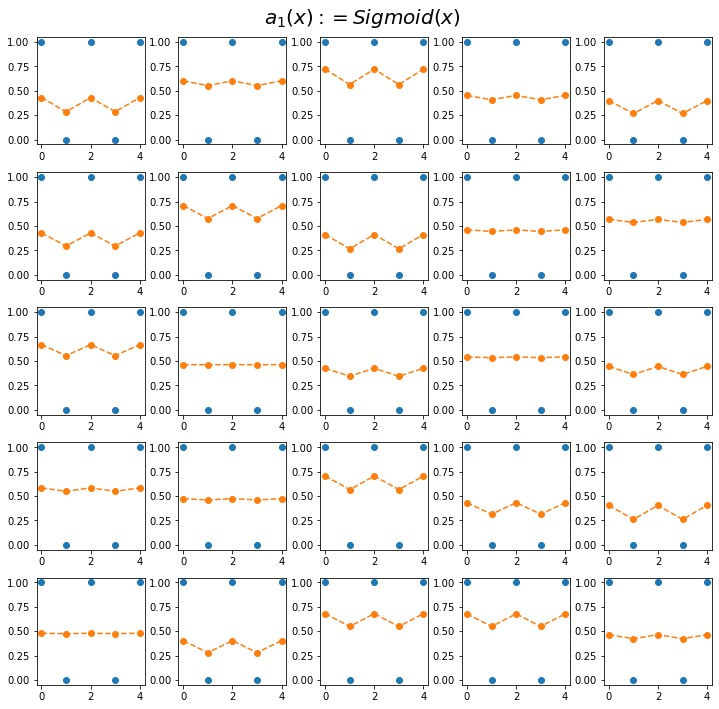

In [70]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet1()
        loss_fn = torch.nn.BCEWithLogitsLoss() 
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            loss = loss_fn(net(x),y)
            loss.backward()
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_1(x):=Sigmoid(x)$",size=20)
fig.tight_layout()

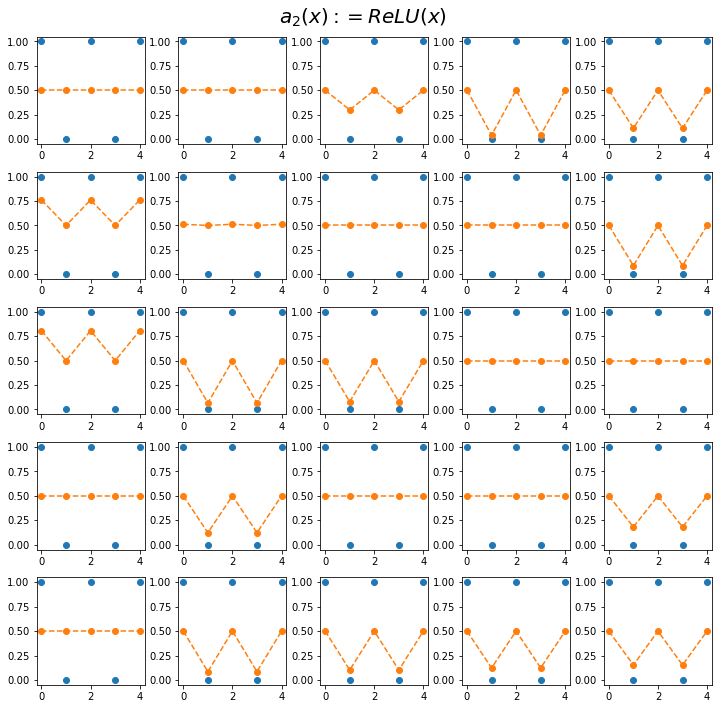

In [71]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet2()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            loss = loss_fn(net(x),y)
            loss.backward()
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_2(x):=ReLU(x)$",size=20)
fig.tight_layout()

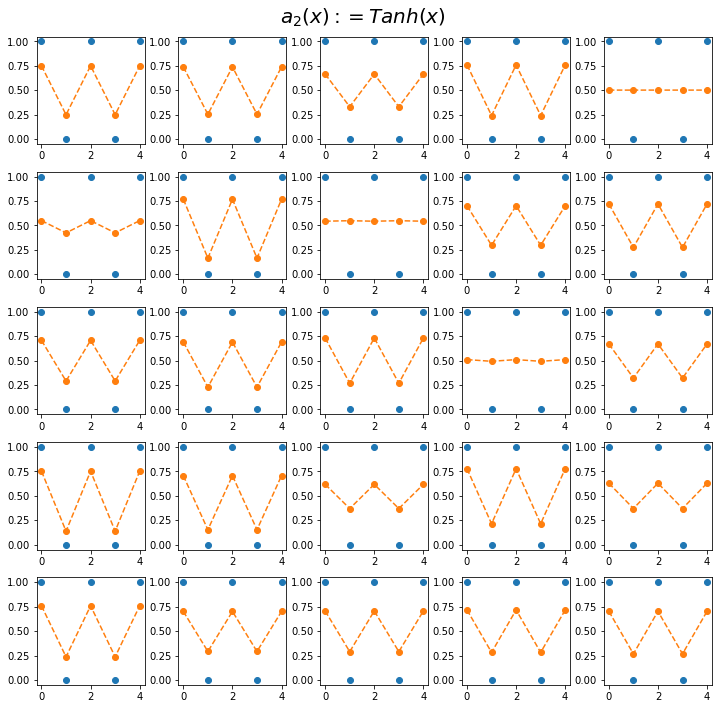

In [72]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = Mynet3()
        loss_fn = torch.nn.BCEWithLogitsLoss()
        optimizr = torch.optim.Adam(net.parameters())
        for epoc in range(1000):
            loss = loss_fn(net(x),y)
            loss.backward()
            optimizr.step()
            optimizr.zero_grad()
        ax[i][j].plot(y[:5],'o')
        ax[i][j].plot(sig(net(x[:5])).data,'--o')
fig.suptitle(r"$a_2(x):=Tanh(x)$",size=20)        
fig.tight_layout()

`-` 실험해석
- sig: 주황색선 변동폭 작음 + `항상` 0.5 근처로 머무는 적합값 존재 
- relu: 주황색선 변동폭 큼 + `항상` 0.5근처로 머무는 적합값 존재 
- tanh: 주황색선 변동폭 큼 + 0.5근처로 머무는 적합값 존재X

`-` 실험해보니까 tanh가 우수한것 같다. $\to$ 앞으로는 tanh를 쓰자. 

----

### 소프트맥스로 확장

#### (풀이1) 로지스틱모형에서 3개의 파라메터 버전을 그대로 확장 

In [73]:
mapping = {'a':[1,0],'b':[0,1]} # 소프트 맥스로 확장하기 위해서..
x = torch.tensor(f(txt_x,mapping)).float().reshape(-1,2)
y = torch.tensor(f(txt_y,mapping)).float().reshape(-1,2)

In [74]:
net = torch.nn.Sequential(
    torch.nn.Linear(2,1), # 입력이 원핫 인코딩 형태임.. -> 그래서 2,1  // hidden node 2
    torch.nn.Tanh(),
    torch.nn.Linear(1,2,bias=False) # 다시 원핫인코딩 형태로 변형해줘야 하기 때문에..
)
loss_fn = torch.nn.CrossEntropyLoss() # 소프트 맥스로 확장하기 위해서..
optimizr = torch.optim.Adam(net.parameters())

In [75]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

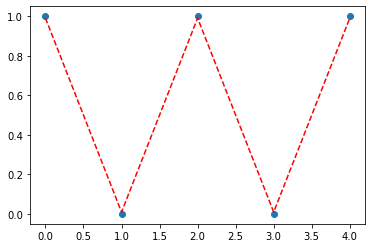

In [76]:
plt.plot(y[:5][:,1],'o')
plt.plot(soft(net(x[:5]))[:,1].data,'--r')

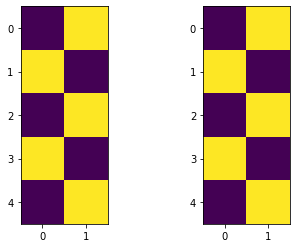

In [77]:
fig,ax = plt.subplots(1,2)
ax[0].imshow(y[:5])
ax[1].imshow(soft(net(x[:5])).data)

## Embedding Layer

`-` 결국 최종적으로는 아래와 같은 맵핑방식이 확장성이 있어보인다. 

In [78]:
mapping = {'a':[1,0,0],'b':[0,1,0],'c':[0,0,1]} # 원핫인코딩 방식 

`-` 그런데 매번 $X$를 원핫인코딩하고 Linear 변환하는것이 번거로운데 이를 한번에 구현하는 함수가 있으면 좋겠다
  - $\to$ torch.nn.Embedding Layer가 그 역할을 한다. 

In [22]:
mapping = {'a':0,'b':1,'c':2}
x = torch.tensor(f(list('abc')*100,mapping))
y = torch.tensor(f(list('bca')*100,mapping))

In [23]:
torch.manual_seed(43052)
ebdd = torch.nn.Embedding(3,1) # hidden node : 1

In [24]:
ebdd(x)[:6]

tensor([[-0.8178],
        [-0.7052],
        [-0.5843],
        [-0.8178],
        [-0.7052],
        [-0.5843]], grad_fn=<SliceBackward0>)

`-` 그런데 사실 언뜻보면 아래의 linr 함수와 역할의 차이가 없어보인다. 

In [30]:
torch.manual_seed(43052)
linr = torch.nn.Linear(1,1)

In [31]:
linr(x.float().reshape(-1,1))[:5]

tensor([[-0.8470],
        [-1.1937],
        [-1.5404],
        [-0.8470],
        [-1.1937]], grad_fn=<SliceBackward0>)

`-` 차이점: 파라메터수에 차이가 있다. 

In [32]:
ebdd.weight, ebdd.weight.shape

(Parameter containing:
 tensor([[-0.8178],
         [-0.7052],
         [-0.5843]], requires_grad=True),
 torch.Size([3, 1]))

In [33]:
linr.weight, linr.bias

(Parameter containing:
 tensor([[-0.3467]], requires_grad=True),
 Parameter containing:
 tensor([-0.8470], requires_grad=True))

결국 ebdd는 아래의 구조에 해당하는 파라메터들이고 

- $\text{x[:5]}= \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \Longrightarrow \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix} \quad, net(x)= \begin{bmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix}\begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \end{bmatrix} = \begin{bmatrix} -0.8178 \\ -0.7052 \\ -0.5843 \\ -0.8178 \\ -0.7052  \end{bmatrix} $

- 반환 결과 feature의 shape이 1임을 알 수 있다. 

linr는 아래의 구조에 해당하는 파라메터이다. 

- $\text{x[:5]}= \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \quad net(x)=  \begin{bmatrix} 0 \\ 1 \\ 2 \\ 0 \\ 1 \end{bmatrix} \times (-0.3467) + (-0.8470)=\begin{bmatrix} -0.8470 \\ -1.1937 \\ -1.5404 \\ -0.8470 \\ -1.1937 \end{bmatrix}$

### 연습 (ab문제 소프트맥스로 확장한 것 다시 풀이)

`-` 맵핑

In [60]:
mapping = {'a':0,'b':1}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))

`-` torch.nn.Embedding 을 넣은 네트워크 

In [48]:
net = torch.nn.Sequential(
    torch.nn.Embedding(2,1),# 입력이 두개, hidden node :1
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1,out_features=2) 
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

`-` 학습

In [93]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

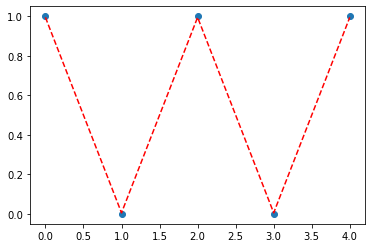

In [94]:
plt.plot(y[:5],'o')
plt.plot(soft(net(x[:5]))[:,1].data,'--r')

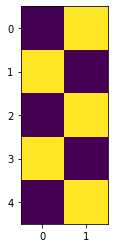

In [95]:
plt.imshow(soft(net(x[:5])).data)

## HW

In [63]:
x = [0,1]*5
y = [1,0]*5
ebdd = torch.nn.Embedding(2,1)

In [64]:
ebdd.weight

Parameter containing:
tensor([[0.7943],
        [0.6712]], requires_grad=True)

In [65]:
ebdd(torch.tensor(x))

tensor([[0.7943],
        [0.6712],
        [0.7943],
        [0.6712],
        [0.7943],
        [0.6712],
        [0.7943],
        [0.6712],
        [0.7943],
        [0.6712]], grad_fn=<EmbeddingBackward0>)

---

---

---

## Exam2: abc

In [3]:
txt = list('abc')*100

In [4]:
txt_x = txt[:-1]
txt_y = txt[1:]

### 하나의 은닉노드를 이용한 풀이 -- 억지로 성공

`-` 데이터정리 

In [10]:
mapping = {'a':0,'b':1,'c':2}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))

`-` 학습

In [15]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(3,1), # 원핫인코딩 + 선형변환(output=1) : 은닉노드는 한 개
    torch.nn.Tanh(), # 활성화 함수 
    #여기까지 hidden...
    torch.nn.Linear(1,3)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [16]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

In [17]:
hidden = net[:-1](x).data # net에서 두 번째 선형변환은 제외한 net
yhat = soft(net(x)).data

`-` 결과시각화1

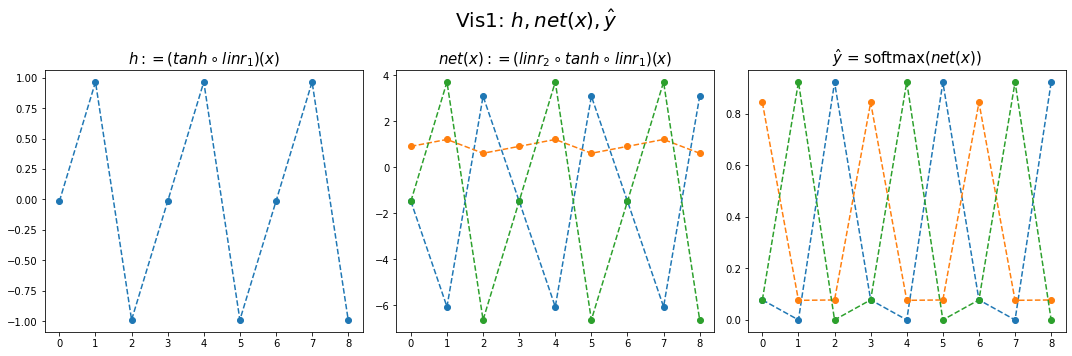

In [18]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(hidden[:9],'--o'); ax[0].set_title('$h:=(tanh \circ linr_1)(x)$',size=15)
ax[1].plot(net(x).data[:9],'--o'); ax[1].set_title('$net(x):=(linr_2 \circ tanh \circ linr_1)(x)$',size=15)
ax[2].plot(yhat[:9],'--o'); ax[2].set_title('$\hat{y}$ = softmax$(net(x))$',size=15);
fig.suptitle(r"Vis1: $h,net(x),\hat{y}$",size=20)
plt.tight_layout()

- 억지로 맞추고있긴한데 파라메터가 부족해보인다. 
  - parameter가 부족해 보인다? = 확확 구분되게 값이 산출 안 됨

In [19]:
# 두 번째 선형변환의 가중치와 편향
(net[-1].weight.data).T, net[-1].bias.data

(tensor([[-4.6804,  0.3071,  5.2894]]), tensor([-1.5440,  0.9143, -1.3970]))

In [ ]:
hidden[:9]@(net[-1].weight.data).T + net[-1].bias.data

tensor([[-1.4755,  0.9098, -1.4745],
        [-6.0618,  1.2108,  3.7086],
        [ 3.0875,  0.6104, -6.6312],
        [-1.4755,  0.9098, -1.4745],
        [-6.0618,  1.2108,  3.7086],
        [ 3.0875,  0.6104, -6.6312],
        [-1.4755,  0.9098, -1.4745],
        [-6.0618,  1.2108,  3.7086],
        [ 3.0875,  0.6104, -6.6312]])

- (파랑,주황,초록) 순서로 그려짐 
- 파랑 = hidden * (-4.6804) + (-1.5440) 
- 주황 = hidden * (0.3071) + (0.9143) 
- 초록 = hidden * (5.2894) + (-1.3970) 

`-` 엄청 위태위태하게 맞추고 있었음. 
- weight: 파랑과 초록을 구분하는 역할을 함 
- weight + bias: 뭔가 애매한 주황값을 만들어서 'b'라고 나올 확률을 학습시킨다. 

$\to$ 사실 학습하는 것 같지 않고 때려 맞추는 느낌, 쓸수있는 weight가 한정적이라서 생기는 현상 (양수 or 음수 or 0) 

--- 

`-` 결과시각화2

In [20]:
combined  = torch.concat([hidden,net(x).data,yhat],axis=1) # 이때 hidden은 두 번째 선형변환은 제외한 network
combined.shape

torch.Size([299, 7])

Text(0.5, 1.0, 'Vis2: $[hidden | net(x) | \\hat{y}]$')

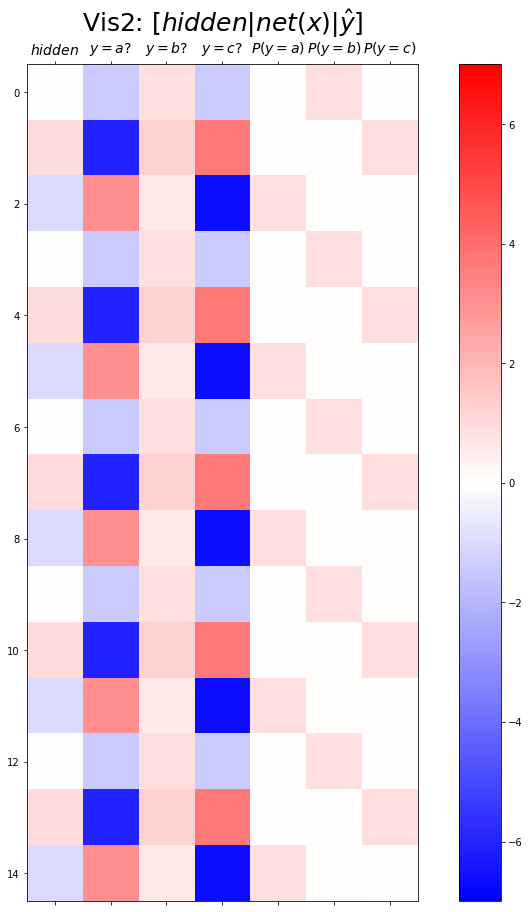

In [28]:
plt.matshow(combined[:15],vmin=-7,vmax=7,cmap='bwr')
plt.xticks(range(7), labels=[r'$hidden$',r'$y=a?$',r'$y=b?$',r'$y=c?$',r'$P(y=a)$',r'$P(y=b)$',r'$P(y=c)$'],size=14)
plt.colorbar()
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(15)
plt.title(r"Vis2: $[hidden | net(x) | \hat{y}]$",size=25)

## Exam3: abcd

In [29]:
txt = list('abcd')*100

In [31]:
txt_x = txt[:-1]
txt_y = txt[1:]

### 하나의 은닉노드를 이용한 풀이 -- 억지로 성공 

In [32]:
mapping = {'a':0,'b':1,'c':2,'d':3}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))

`-` 학습

In [33]:
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=1),#hidden node : 1
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1,out_features=4)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [34]:
net[0].weight.data = torch.tensor([[-0.3333],[-2.5000],[5.0000],[0.3333]]) 
# embedding은 원핫인코딩 + 선형변환인데
# 이때 선형변환은 가중치만 곱해진 결과임
# embedding에서의 선형변환은 편향은 더하지 않음


# 히든 노드가.....1인데 그냥 가중치를 억지로 조정해서 맞춘 거.................
# 가중치와 편향이 어떤 형태여야 성공하기 쉬울까? 생각해보자..


net[-1].weight.data = torch.tensor([[1.5000],[-6.0000],[-2.0000],[6.0000]])
net[-1].bias.data = torch.tensor([0.1500, -2.0000,  0.1500, -2.000])

In [35]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화1

In [36]:
hidden = net[:-1](x).data
yhat = soft(net(x)).data

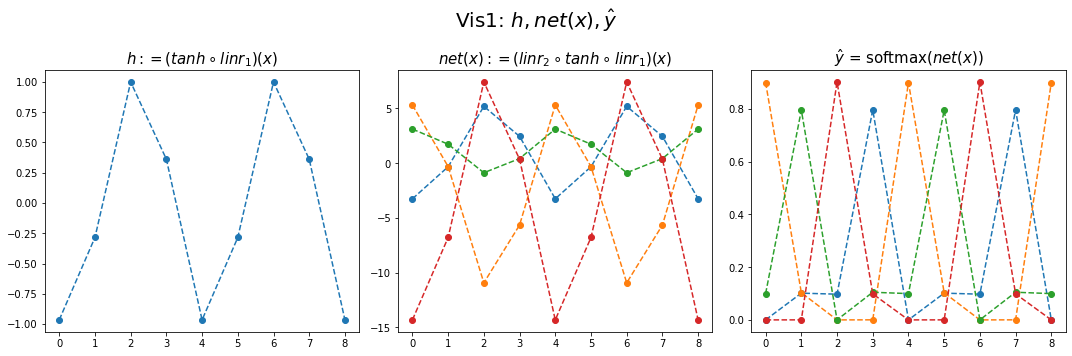

In [37]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(hidden[:9],'--o'); ax[0].set_title('$h:=(tanh \circ linr_1)(x)$',size=15)
ax[1].plot(net(x).data[:9],'--o'); ax[1].set_title('$net(x):=(linr_2 \circ tanh \circ linr_1)(x)$',size=15)
ax[2].plot(yhat[:9],'--o'); ax[2].set_title('$\hat{y}$ = softmax$(net(x))$',size=15);
fig.suptitle(r"Vis1: $h,net(x),\hat{y}$",size=20)
plt.tight_layout()

`-` 결과시각화2

In [38]:
combined  = torch.concat([hidden,net(x).data,yhat],axis=1)
combined.shape

torch.Size([399, 9])

Text(0.5, 1.0, 'Vis2: $[h | net(x) | \\hat{y}]$')

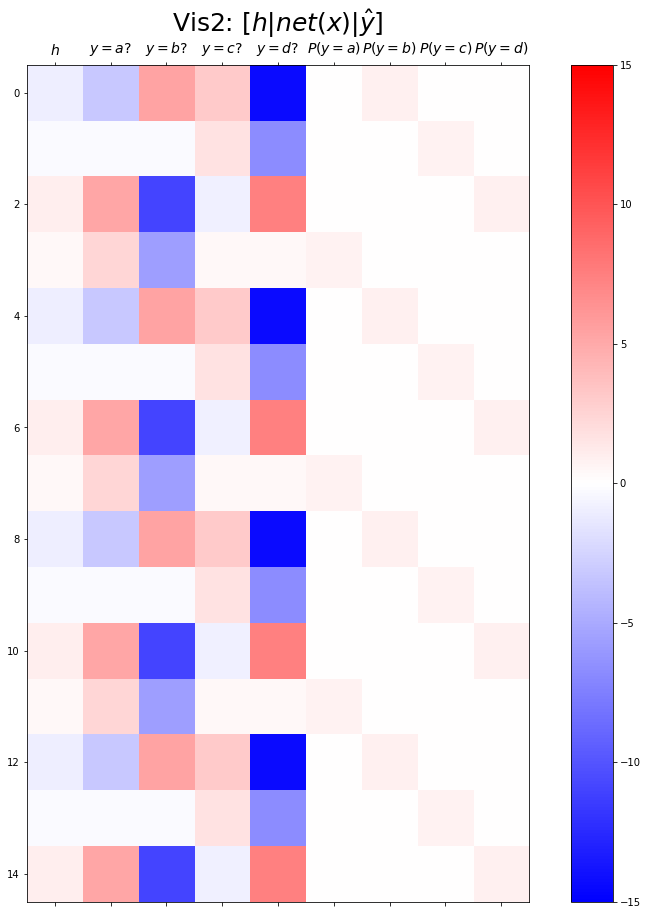

In [39]:
plt.matshow(combined[:15],vmin=-15,vmax=15,cmap='bwr')
plt.xticks(range(9), labels=[r'$h$',r'$y=a?$',r'$y=b?$',r'$y=c?$',r'$y=d?$',r'$P(y=a)$',r'$P(y=b)$',r'$P(y=c)$',r'$P(y=d)$'],size=14)
plt.colorbar()
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(15)
plt.title(r"Vis2: $[h | net(x) | \hat{y}]$",size=25)

### 두개의 은닉노드를 이용한 풀이 -- 깔끔한 성공

`-` 데이터정리 

In [34]:
mapping = {'a':0,'b':1,'c':2,'d':3}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))

`-` 학습

In [35]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=2), # 2개의 은닉노드
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=2,out_features=4)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [42]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화1

In [43]:
hidden = net[:-1](x).data
yhat = soft(net(x)).data

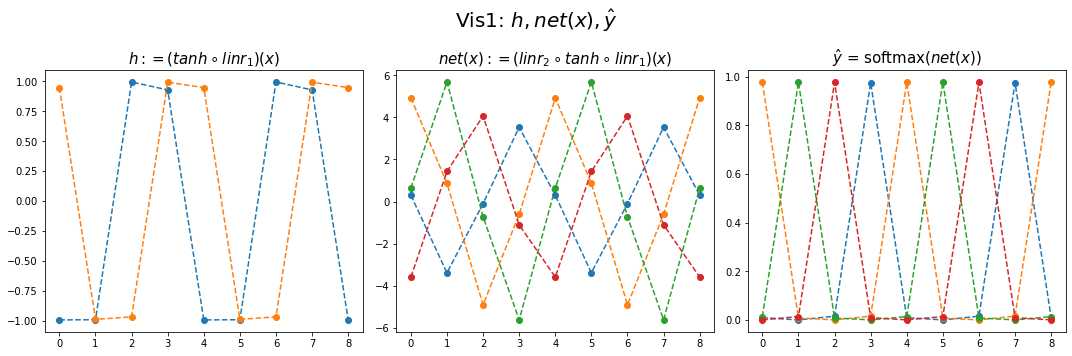

In [45]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(hidden[:9],'--o'); ax[0].set_title('$h:=(tanh \circ linr_1)(x)$',size=15)
ax[1].plot(net(x).data[:9],'--o'); ax[1].set_title('$net(x):=(linr_2 \circ tanh \circ linr_1)(x)$',size=15)
ax[2].plot(yhat[:9],'--o'); ax[2].set_title('$\hat{y}$ = softmax$(net(x))$',size=15);
fig.suptitle(r"Vis1: $h,net(x),\hat{y}$",size=20)
plt.tight_layout()

`-` 결과시각화2

In [46]:
combined  = torch.concat([hidden,net(x).data,yhat],axis=1)
combined.shape

torch.Size([399, 10])

Text(0.5, 1.0, 'Vis2: $[h | net(x) | \\hat{y}]$')

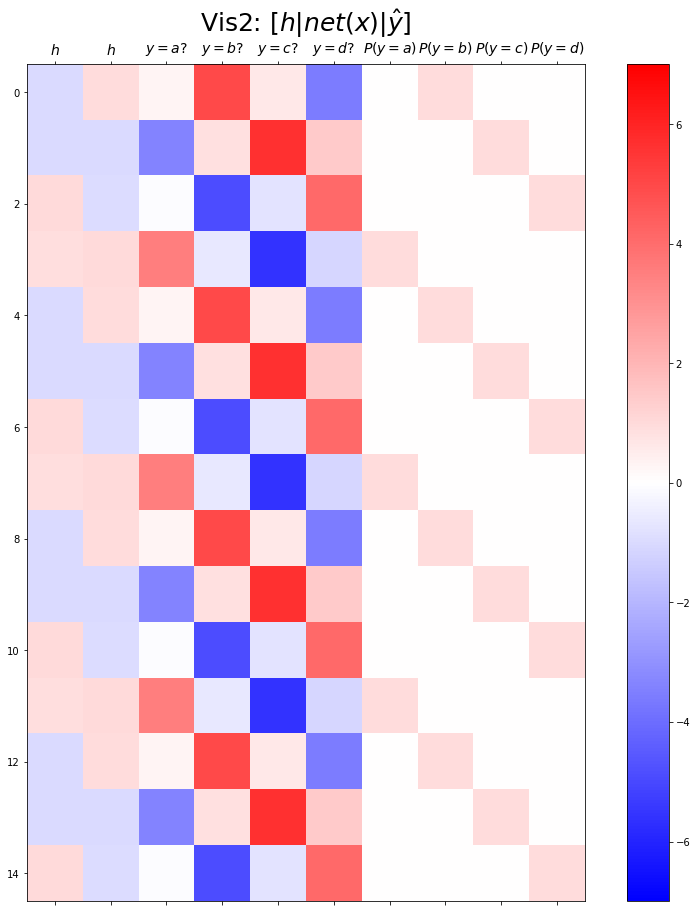

In [47]:
plt.matshow(combined[:15],vmin=-7,vmax=7,cmap='bwr')
plt.xticks(range(10), labels=[r'$h$',r'$h$',r'$y=a?$',r'$y=b?$',r'$y=c?$',r'$y=d?$',r'$P(y=a)$',r'$P(y=b)$',r'$P(y=c)$',r'$P(y=d)$'],size=14)
plt.colorbar()
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(15)
plt.title(r"Vis2: $[h | net(x) | \hat{y}]$",size=25)

## Exam4: AbAcAd

### data

In [50]:
txt = list('AbAcAd')*100

In [51]:
txt_x = txt[:-1]
txt_y = txt[1:]

### 두개의 은닉노드를 이용한 풀이 -- 실패

`-` 데이터정리 

In [53]:
mapping = {'A':0,'b':1,'c':2,'d':3}
x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))

`-` 학습

In [54]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=2),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=2,out_features=4)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [55]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화1

In [56]:
hidden = net[:-1](x).data
yhat = soft(net(x)).data

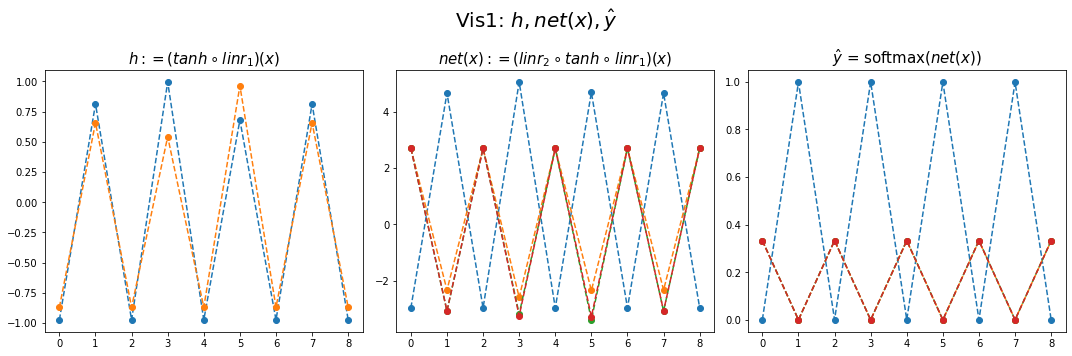

In [57]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(hidden[:9],'--o'); ax[0].set_title('$h:=(tanh \circ linr_1)(x)$',size=15)
ax[1].plot(net(x).data[:9],'--o'); ax[1].set_title('$net(x):=(linr_2 \circ tanh \circ linr_1)(x)$',size=15)
ax[2].plot(yhat[:9],'--o'); ax[2].set_title('$\hat{y}$ = softmax$(net(x))$',size=15);
fig.suptitle(r"Vis1: $h,net(x),\hat{y}$",size=20)
plt.tight_layout()

`-` 결과시각화2

In [58]:
combined  = torch.concat([hidden,net(x).data,yhat],axis=1)
combined.shape

torch.Size([599, 10])

Text(0.5, 1.0, 'Vis2: $[h | net(x) | \\hat{y}]$')

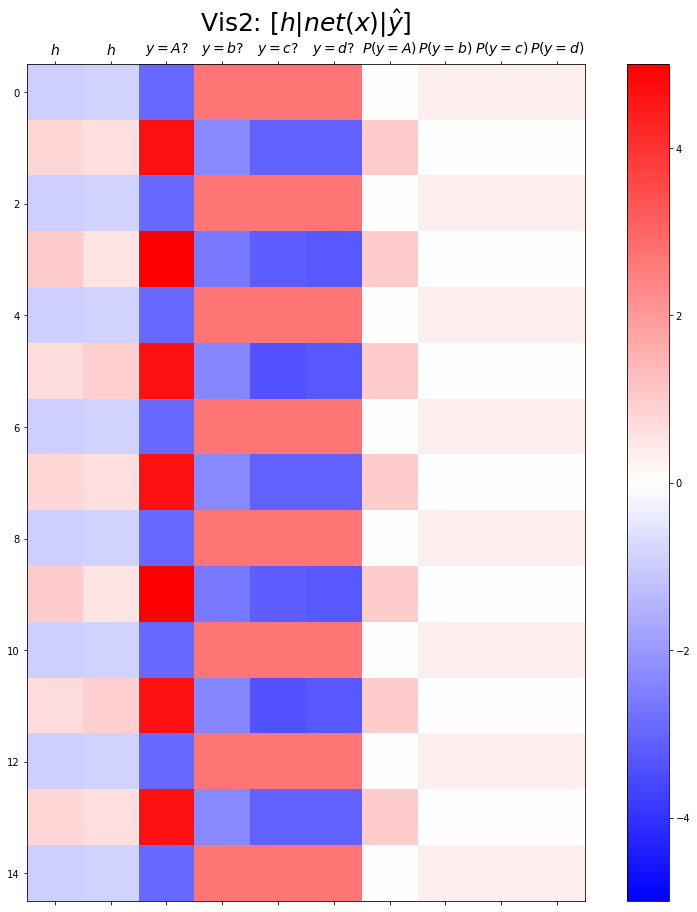

In [59]:
plt.matshow(combined[:15],vmin=-5,vmax=5,cmap='bwr')
plt.xticks(range(10), labels=[r'$h$',r'$h$',r'$y=A?$',r'$y=b?$',r'$y=c?$',r'$y=d?$',r'$P(y=A)$',r'$P(y=b)$',r'$P(y=c)$',r'$P(y=d)$'],size=14)
plt.colorbar()
plt.gcf().set_figwidth(15)
plt.gcf().set_figheight(15)
plt.title(r"Vis2: $[h | net(x) | \hat{y}]$",size=25)

`-` 실패를 해결하는 순진한 접근방식: 위 문제를 해결하기 위해서는 아래와 같은 구조로 데이터를 다시 정리하면 될 것이다. 

|X|y|
|:-:|:-:|
|A,b|A|
|b,A|c|
|A,c|A|
|c,A|d|
|A,d|A|
|d,A|b|
|A,b|A|
|b,A|c|
|...|...|

`-` 순진한 접근방식의 비판: 
- 결국 정확하게 직전 2개의 문자를 보고 다음 문제를 예측하는 구조
- 만약에 직전 3개의 문자를 봐야하는 상황이 된다면 또 다시 코드를 수정해야함. 
- 그리고 실전에서는 직전 몇개의 문자를 봐야하는지 모름. 

> ***이것에 대한 해결책은 순환신경망이다***

## 숙제

주어진 자료가 다음과 같다고 하자. 

In [92]:
txt = list('abcde')*100

txt_x = txt[:-1]
txt_y = txt[1:]

mapping = {'a':0,'b':1,'c':2,'d':3,'e':4}

x = torch.tensor(f(txt_x,mapping))
y = torch.tensor(f(txt_y,mapping))

In [93]:
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=5,embedding_dim=2),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=2,out_features=5)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())

In [94]:
for epoc in range(5000):
    loss = loss_fn(net(x),y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

In [95]:
hidden = net[:-1](x).data
yhat = soft(net(x)).data

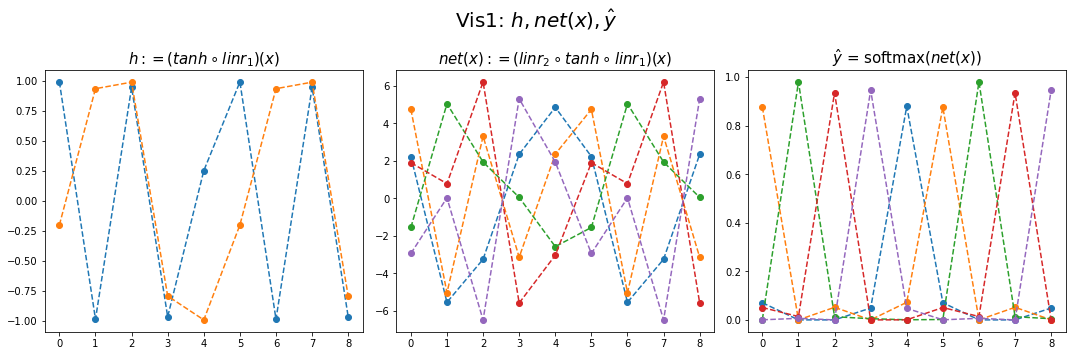

In [96]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(hidden[:9],'--o'); ax[0].set_title('$h:=(tanh \circ linr_1)(x)$',size=15)
ax[1].plot(net(x).data[:9],'--o'); ax[1].set_title('$net(x):=(linr_2 \circ tanh \circ linr_1)(x)$',size=15)
ax[2].plot(yhat[:9],'--o'); ax[2].set_title('$\hat{y}$ = softmax$(net(x))$',size=15);
fig.suptitle(r"Vis1: $h,net(x),\hat{y}$",size=20)
plt.tight_layout()